In [56]:
# this is a new version for CVPR (just after ICLR reviews)
# first change is to read in csvs from anywhere

In [57]:
import os, shutil
from os import listdir
from os.path import join, isdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

%config InlineBackend.figure_format = 'svg'

In [58]:
def list_folders_only(path):
    return [x for x in listdir(path) if isdir(join(path, x))]


def parse_folder_name(foldername):
    """ Get the CNN hyperparameters from the 
        folder name where results are stored.
    """
    model_spec = {}

    foldername = foldername[foldername.find('con')+4:]
    if foldername[:foldername.find('_')]=='False':
        model_spec['human'] = True
    else:
        model_spec['human'] = False
    foldername = foldername[foldername.find('lr_')+3:]
    model_spec['lr'] = float(foldername[:foldername.find('_')])
    foldername = foldername[foldername.find('seed')+5:]
    
    if 'mixupalpha' in foldername:
        model_spec['seed'] = int(foldername[:foldername.find('_')])
        foldername = foldername[foldername.find('_')+12:]
        model_spec['mixup_alpha'] = float(foldername)
    else:
        model_spec['seed'] = int(foldername)
    
    return model_spec


def get_meta(out_path):
    csv_paths = []
    model_folders = sorted(list_folders_only(out_path))
    
    model_specs = []
    for model_folder in model_folders:
        param_folders = list_folders_only(join(out_path, model_folder))
        param_folders = sorted(param_folders)

        for param_folder in param_folders:
            model_spec = parse_folder_name(param_folder)
            model_spec['model_name'] = model_folder
            model_spec['param_set_id'] = param_folder
            model_specs.append(model_spec)

    return model_specs

In [59]:
# out_path = '../../../../joshuacp/model_results/mixup_250_run1/'
# out_path = '../../../../joshuacp/model_results/mixup_250_run2/'
# out_path = '../../../../joshuacp/model_results/sampling_run1/'
out_path = '../../../../ruairidh/model_results/basic_tuning_run_1/'
model_specs = get_meta(out_path)

In [60]:
def create_master_df(out_path, model_specs):
    # merge all data into one big pandas df
    for i, model_spec in enumerate(model_specs):

        # read csv
        csv_path = join(out_path, model_spec['model_name'], 
                                  model_spec['param_set_id'], 
                                  'scores.csv')
        current_df = pd.read_csv(csv_path)
        if (current_df.shape[0]-1) % 10 != 0:
            size_warning = 'WARNING: '
            size_warning += model_spec['model_name']
            size_warning += ' has odd # of epochs: '+str(current_df.shape[0])
            print(size_warning)

        # add meta to current csv
        for key in model_spec.keys():
            #if key != 'param_set_id': 
            current_df[key] = model_spec[key]

        if i == 0:
            df = current_df.copy()
        else:
            df = pd.concat([df, current_df])

    df = df.reset_index(drop=True)
    #df = df[[col for col in df.columns if col != 'index']]
    return df
    
df = create_master_df(out_path, model_specs)
print([_ for _ in df.keys()])
df.head()

['epoch', 'c10h_train_loss', 'c10h_train_acc', 'c10h_val_loss', 'c10h_val_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc', 'c10h_val_c10_loss', 'c10h_val_c10_acc', 'v4_loss', 'v4_acc', 'v6_loss', 'v6_acc', 'c10_50k_loss', 'c10_50k_acc', 'human', 'lr', 'seed', 'model_name', 'param_set_id']


,epoch,c10h_train_loss,c10h_train_acc,c10h_val_loss,c10h_val_acc,c10h_train_c10_loss,c10h_train_c10_acc,c10h_val_c10_loss,c10h_val_c10_acc,v4_loss,v4_acc,v6_loss,v6_acc,c10_50k_loss,c10_50k_acc,human,lr,seed,model_name,param_set_id
0,0,0.627269,0.941111,0.613540,0.961,0.212312,0.943222,0.147656,0.962,0.543438,0.885700,0.541001,0.8890,0.000311,1.0,True,0.00001,0,densenet_BC_100_12,con_False_lr_0.00001_seed_0
1,1,0.627400,0.942778,0.616473,0.956,0.212227,0.945000,0.149988,0.959,0.555160,0.885700,0.550875,0.8885,0.000320,1.0,True,0.00001,0,densenet_BC_100_12,con_False_lr_0.00001_seed_0
2,2,0.613889,0.944333,0.613339,0.962,0.193991,0.947111,0.147653,0.965,0.552464,0.886690,0.547359,0.8900,0.000309,1.0,True,0.00001,0,densenet_BC_100_12,con_False_lr_0.00001_seed_0
3,3,0.617709,0.943111,0.608520,0.959,0.204218,0.945556,0.145669,0.960,0.541441,0.887679,0.538384,0.8905,0.000312,1.0,True,0.00001,0,densenet_BC_100_12,con_False_lr_0.00001_seed_0
4,4,0.618990,0.943889,0.605240,0.958,0.205966,0.945667,0.144998,0.961,0.546701,0.885205,0.542940,0.8880,0.000338,1.0,True,0.00001,0,densenet_BC_100_12,con_False_lr_0.00001_seed_0


In [63]:
benchmark_data = []

for mn in df.model_name.unique()[::-1]:
    
    for ht in df.human.unique(): # will be [True, False], or [False] for example

        if ht:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_loss.idxmin() # DEFAULT!
#             idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_c10_loss.idxmin() # NOT DEFAULT!
        else:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_c10_loss.idxmin() # DEFAULT!
            """
                 WARNING: change this back!!!
            """
#             idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_loss.idxmin()
            #print
            
        row = dict(df[(df.model_name==mn) & (df.human==ht)].loc[idxmin])

        benchmark_data.append(row)
        
        try: 
            hp_selector = (df.model_name==mn) & \
                          (df.human==ht) & \
                          (df.lr==row['lr']) & \
                          (df.seed==row['seed']) & \
                          (df.mixup_alpha==row['mixup_alpha']) & \
                          (df.epoch==0)
        except:
            hp_selector = (df.model_name==mn) & \
                          (df.human==ht) & \
                          (df.lr==row['lr']) & \
                          (df.seed==row['seed']) & \
                          (df.epoch==0)
        ep0_row = dict(df[hp_selector].reset_index(drop=True).loc[0])
        benchmark_data.append(ep0_row)

b_df = pd.DataFrame(benchmark_data)

display_cols = ['c10h_val_c10_loss','c10h_val_loss','v4_loss','v6_loss',
                'human','lr','seed','epoch', 'model_name','param_set_id']
if 'mixup_alpha' in b_df.columns: display_cols += ['mixup_alpha']
# b_df[b_df['human']==False][display_cols]
b_df[display_cols]

,c10h_val_c10_loss,c10h_val_loss,v4_loss,v6_loss,human,lr,seed,epoch,model_name,param_set_id
0,0.126677,0.274410,0.320065,0.314109,True,0.01000,0,67,wrn_28_10,con_False_lr_0.01_seed_0
1,0.156374,0.444786,0.400552,0.387480,True,0.01000,0,0,wrn_28_10,con_False_lr_0.01_seed_0
2,0.119227,0.416608,0.365100,0.357775,False,0.00100,1,3,wrn_28_10,con_True_lr_0.001_seed_1
3,0.138251,0.462641,0.400552,0.387480,False,0.00100,1,0,wrn_28_10,con_True_lr_0.001_seed_1
4,0.207078,0.344266,0.493957,0.479760,True,0.01000,0,86,vgg_15_BN_64,con_False_lr_0.01_seed_0
5,0.258883,0.705523,0.787436,0.760921,True,0.01000,0,0,vgg_15_BN_64,con_False_lr_0.01_seed_0
6,0.203521,0.539391,0.615422,0.586111,False,0.00100,0,38,vgg_15_BN_64,con_True_lr_0.001_seed_0
7,0.258883,0.705523,0.787436,0.760921,False,0.00100,0,0,vgg_15_BN_64,con_True_lr_0.001_seed_0
8,0.100743,0.258660,0.267577,0.264162,True,0.01000,0,69,shake_shake_26_2x64d_SSI_cutout16,con_False_lr_0.01_seed_0
9,0.088035,0.547938,0.339057,0.332181,True,0.01000,0,0,shake_shake_26_2x64d_SSI_cutout16,con_False_lr_0.01_seed_0


In [68]:
in_path = '../../../../ruairidh/model_results/basic_tuning_run_1/'
cp_path = '../../../../joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/'

df_to_transfer = b_df[display_cols].copy()
df_to_transfer = df_to_transfer[df_to_transfer.epoch!=0].reset_index(drop=True)
df_to_transfer

,c10h_val_c10_loss,c10h_val_loss,v4_loss,v6_loss,human,lr,seed,epoch,model_name,param_set_id
0,0.126677,0.274410,0.320065,0.314109,True,0.01000,0,67,wrn_28_10,con_False_lr_0.01_seed_0
1,0.119227,0.416608,0.365100,0.357775,False,0.00100,1,3,wrn_28_10,con_True_lr_0.001_seed_1
2,0.207078,0.344266,0.493957,0.479760,True,0.01000,0,86,vgg_15_BN_64,con_False_lr_0.01_seed_0
3,0.203521,0.539391,0.615422,0.586111,False,0.00100,0,38,vgg_15_BN_64,con_True_lr_0.001_seed_0
4,0.100743,0.258660,0.267577,0.264162,True,0.01000,0,69,shake_shake_26_2x64d_SSI_cutout16,con_False_lr_0.01_seed_0
5,0.069204,0.506137,0.276544,0.267686,False,0.00010,1,123,shake_shake_26_2x64d_SSI_cutout16,con_True_lr_0.0001_seed_1
6,0.128911,0.288855,0.339002,0.331440,True,0.00100,0,57,resnext_29_8x64d,con_False_lr_0.001_seed_0
7,0.096087,0.455587,0.348001,0.338978,False,0.00001,1,30,resnext_29_8x64d,con_True_lr_0.00001_seed_1
8,0.212531,0.350871,0.487865,0.483770,True,0.10000,1,115,resnet_preact_bottleneck_164,con_False_lr_0.1_seed_1
9,0.189287,0.649390,0.611556,0.588160,False,0.00100,2,33,resnet_preact_bottleneck_164,con_True_lr_0.001_seed_2


In [79]:
for i in range(df_to_transfer.shape[0]):
#     to_copy = join(in_path, 
#                    df_to_transfer.loc[i].model_name,
#                    df_to_transfer.loc[i].param_set_id)
#     print(to_copy)
    # MAKE ARCH FOLDER (WHICH TYPE OF MODEL. e.g., vgg_15_BN_64)
    arch_folder = join(cp_path, df_to_transfer.loc[i].model_name)
    if not os.path.exists(arch_folder):
        os.makedirs(arch_folder)
    # MAKE MODEL (PARAM SET) FOLDER, e.g., con_False_lr_0.01_seed_0
    param_folder = join(cp_path, 
                        df_to_transfer.loc[i].model_name, 
                        df_to_transfer.loc[i].param_set_id)
    if not os.path.exists(param_folder):
        os.makedirs(param_folder)
        
    source = join(in_path, 
                  df_to_transfer.loc[i].model_name,
                  df_to_transfer.loc[i].param_set_id)
    destination = join(cp_path, 
                       df_to_transfer.loc[i].model_name,
                       df_to_transfer.loc[i].param_set_id)
    
    if 'con_False' in df_to_transfer.loc[i].param_set_id:
        source = join(source, 'model_best_state_c10h_val_loss.pth')
        destination = join(destination, 'model_best_state_c10h_val_loss.pth')
    else:
        source = join(source, 'model_best_state_c10h_val_c10_loss.pth')
        destination = join(destination, 'model_best_state_c10h_val_c10_loss.pth')
        
    print(source)
    print(destination)
    print('')
#     shutil.copy(source, destination)

../../../../ruairidh/model_results/basic_tuning_run_1/wrn_28_10/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth
../../../../joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/wrn_28_10/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth

../../../../ruairidh/model_results/basic_tuning_run_1/wrn_28_10/con_True_lr_0.001_seed_1/model_best_state_c10h_val_c10_loss.pth
../../../../joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/wrn_28_10/con_True_lr_0.001_seed_1/model_best_state_c10h_val_c10_loss.pth

../../../../ruairidh/model_results/basic_tuning_run_1/vgg_15_BN_64/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth
../../../../joshuacp/model_results/optimal_basic_tuning_josh_alt_controls/vgg_15_BN_64/con_False_lr_0.01_seed_0/model_best_state_c10h_val_loss.pth

../../../../ruairidh/model_results/basic_tuning_run_1/vgg_15_BN_64/con_True_lr_0.001_seed_0/model_best_state_c10h_val_c10_loss.pth
../../../../joshuacp/model_results/optimal_basic

In [39]:
# model_names = ['vgg_15_BN_64', 'densenet_BC_100_12', 'pyramidnet_basic_110_270',
#                'resnet_basic_110', 'resnext_29_8x64d', 
#                'wrn_28_10', 'wrn_28_10_cutout16',
#                'resnet_preact_bottleneck_164',
#                'shake_shake_26_2x64d_SSI_cutout16']

# model_names_trimmed = ['vgg_15_BN_64', 'densenet_BC_100_12', 'pyramidnet_110_270',
#                'resnet_basic_110', 'resnext_29_8x64d', 
#                'wrn_28_10', 'wrn_28_10_co16',
#                'rn_preact_bn_164',
#                'shake_26_2x64d_SSI_co16']

# model_names_trimmed = ['vgg', 'densenet', 'pyramidnet',
#                'resnet', 'resnext', 
#                'wrn', 'wrn_co',
#                'rn_preact',
#                'shake']

# model_names = ['vgg_15_BN_64', 'densenet_BC_100_12', 'pyramidnet_basic_110_270',
#                'resnet_basic_110',
#                'wrn_28_10', 'wrn_28_10_cutout16',
#                'resnet_preact_bottleneck_164',
#                'shake_shake_26_2x64d_SSI_cutout16']

# model_names_trimmed = ['vgg_15_BN_64', 'densenet_BC_100_12', 'pyramidnet_110_270',
#                'resnet_basic_110',
#                'wrn_28_10', 'wrn_28_10_co16',
#                'rn_preact_bn_164',
#                'shake_26_2x64d_SSI_co16']

# model_names_trimmed = ['vgg', 'densenet', 'pyramidnet',
#                'resnet',
#                'wrn', 'wrn_co',
#                'rn_preact',
#                'shake']



model_names = ['vgg_15_BN_64','densenet_BC_100_12', 
               'pyramidnet_basic_110_270','resnet_basic_110',
               'resnext_29_8x64d','wrn_28_10',
               'resnet_preact_bottleneck_164','shake_shake_26_2x64d_SSI_cutout16']
model_names_trimmed = ['VGG', 'DenseNet', 
                       'PyramidNet','ResNet',
                       'ResNext','Wide Resnet',
                       'ResNet preact', 'Shake-Shake']




# model_names = ['wrn_28_10_cutout16',
#                'shake_shake_26_2x64d_SSI_cutout16']

# model_names_trimmed = ['wrn_28_10_co16',
#                        'shake_26_2x64d_SSI_co16']

In [14]:
# genereate latex table

# \begin{center}
# \begin{tabular}{ c c c }
#  cell1 & cell2 & cell3 \\ 
#  cell4 & cell5 & cell6 \\  
#  cell7 & cell8 & cell9    
# \end{tabular}
# \end{center}

# score_keys = [col for col in b_df.columns if 'c10' in col]
# print(score_keys)



def insert_str(idx, string, add):
    return string[:idx] + add + string[idx:]

# recursive function to make 
# underscores latex compatible
def fix_underscores(string):
    idx = string.find('_')
    if idx == -1: 
        return
    else:
        string = insert_str(string.find('_'), string, '\\')
        up_to = string[:string.find('_')+1]
        after = string[string.find('_')+1:]
        if after.find('_') == -1: return up_to+after
        new_string = up_to + fix_underscores(after)
        return new_string

# print(fix_underscores('c10h_val_loss'))


ordered_keys = ['c10h_val_loss', 'c10h_val_acc',
                'c10h_val_c10_loss', 'c10h_val_c10_acc',
                'v4_loss', 'v4_acc','v6_loss', 'v6_acc',               
                'c10_50k_loss', 'c10_50k_acc']

# print a table give two conditions (epoch, human)
def print_table(b_df, model_names, model_names_trimmed, human, epoch):
    for m, mn in enumerate(model_names):
        if model_names_trimmed[m].find('_') != -1:
            print('\\texttt{'+fix_underscores(model_names_trimmed[m])+'}', end=' & ')
        else:
            print('\\texttt{'+model_names_trimmed[m]+'}', end=' & ')
            
        row_select = (b_df.model_name==mn)&(b_df.human==human)&epoch
        row_data = b_df[row_select]
        if row_data.shape[0]==0:
            row_select = (b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)
            row_data = b_df[row_select]            

        for k, key in enumerate(ordered_keys):
            end = ' & '
            if k == len(ordered_keys) - 1: end = ' \\\\\n'

            if (k+1)%2 != 0:
                val = np.round(row_data[key].values[0], 2) #np.round(0.0, 2)
                print('%.2f' % val, end=' ')
            else:
                acc = np.round(row_data[key].values[0], 2)*100 #np.round(0.0, 2)*100
                print(('(%.0f' % acc ) + '\\%)', end=end)

In [15]:
loss_header = '& c10h val. & c10 val. & c10.1 v4 & c10.1 v6 & c10 50k \\\\'

print('\\begin{center}')
print('\\begin{tabular}{ l l l l l l }')

print("\multicolumn{6}{c}{Pretrained on \\texttt{CIFAR10}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, model_names, model_names_trimmed, False, (b_df.epoch==0))
print("\hline \\\\")

# print("[2ex]")
print("\multicolumn{6}{c}{Fine-tuned on \\texttt{CIFAR10}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, model_names, model_names_trimmed, False, (b_df.epoch!=0))
print("\hline \\\\")

# print("[2ex]")
print("\multicolumn{6}{c}{Fine-tuned on \\texttt{CIFAR10H}}\\\\")
print("\hline  \\\\ [-2.2ex]")
print(loss_header)
print("\hline  \\\\ [-2.1ex]")

print_table(b_df, model_names, model_names_trimmed, True, (b_df.epoch!=0))
print("\hline \\\\")

print('\\end{tabular}')
print('\\end{center}')

\begin{center}
\begin{tabular}{ l l l l l l }
\multicolumn{6}{c}{Pretrained on \texttt{CIFAR10}}\\
\hline  \\ [-2.2ex]
& c10h val. & c10 val. & c10.1 v4 & c10.1 v6 & c10 50k \\
\hline  \\ [-2.1ex]
\texttt{VGG} & 0.71 (94\%) & 0.26 (95\%) & 0.79 (85\%) & 0.76 (85\%) & 0.00 (100\%) \\
\texttt{DenseNet} & 0.61 (96\%) & 0.15 (96\%) & 0.54 (89\%) & 0.54 (89\%) & 0.00 (100\%) \\
\texttt{PyramidNet} & 0.54 (97\%) & 0.12 (97\%) & 0.42 (90\%) & 0.42 (90\%) & 0.00 (100\%) \\
\texttt{ResNet} & 0.82 (94\%) & 0.25 (94\%) & 0.84 (86\%) & 0.82 (86\%) & 0.00 (100\%) \\
\texttt{ResNext} & 0.47 (97\%) & 0.10 (98\%) & 0.37 (90\%) & 0.36 (90\%) & 0.00 (100\%) \\
\texttt{Wide Resnet} & 0.46 (96\%) & 0.14 (97\%) & 0.40 (90\%) & 0.39 (90\%) & 0.00 (100\%) \\
\texttt{ResNet preact} & 0.75 (95\%) & 0.20 (95\%) & 0.69 (86\%) & 0.66 (87\%) & 0.00 (100\%) \\
\texttt{Shake-Shake} & 0.60 (98\%) & 0.09 (98\%) & 0.34 (92\%) & 0.33 (92\%) & 0.00 (100\%) \\
\hline \\
\multicolumn{6}{c}{Fine-tuned on \texttt{CIFAR10}}\\

In [11]:
# colors= ['blue','red']

# plt.figure(figsize=(12,8), dpi=150)

# for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
#     plt.subplot(2, 2, plot_i+1)
#     for m, mn in enumerate(b_df.model_name.unique()[::-1]):

#         for h, human in enumerate([True, False]):
#             start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
#             end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

#             extra = 0.25
#             if h==1: extra=0.45
#             space = 1.0
#             x = m*space-1+extra

# #             plt.plot([x, x], [start, end], color=colors[h], linewidth=1, zorder=-999)
# #             plt.scatter(x, end, marker='o', color='white', s=40, edgecolor=colors[h])
#             plt.annotate('', xy=(x, end), xytext=(x, start+0.008), 
#                          arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
#                          va='center')
#             plt.scatter(x, start, marker='_', color=None, s=0, edgecolor=None)
#             plt.ylim([0.08,0.87])
#             plt.title(loss_key)

#     if plot_i % 2 == 0: plt.ylabel('Crossentropy', fontsize=14)

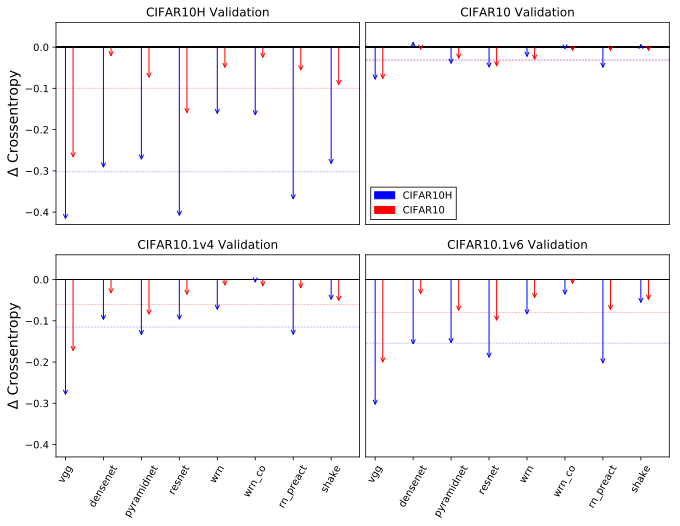

In [25]:
colors= ['blue','red']

plt.figure(figsize=(11,8), dpi=200)

titles = ['CIFAR10H Validation', 'CIFAR10 Validation', 
          'CIFAR10.1v4 Validation', 'CIFAR10.1v6 Validation']

# print(b_df.model_name.unique()[::-1]) # leave for updating!
# model_names = ['vgg_15_BN_64', 'resnext_29_8x64d', 'wrn_28_10', 
#                'resnet_basic_110',
#                'wrn_28_10_cutout16', 'densenet_BC_100_12']
# model_names_fixed = ['vgg', 'resnext', 'wrn', 'resnet', 'wrn_cutout', 'densenet']

for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
    plt.subplot(2, 2, plot_i+1)
    xs = []
    human_mags = []
    nonhuman_mags = []
    for m, mn in enumerate(model_names):

        for h, human in enumerate([True, False]):
            
            start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
            end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

            extra = 0.25
            if h==1: extra=0.45
            space = 1.0
            x = m*space-1+extra
            
            mag = end - start
            if human: 
                human_mags.append(mag)
                xs.append(x)
            else:
                nonhuman_mags.append(mag)

            if mag < 0: 
                plt.annotate('', xy=(x, mag), xytext=(x, 0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            else:
                plt.annotate('', xy=(x, mag), xytext=(x, -0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            plt.scatter(x, mag, marker='_', color=None, s=0, edgecolor=None)
        
            plt.plot([-1, len(model_names)-1], [0, 0], color='black', linewidth=0.6, zorder=-999)
            plt.ylim([-0.43, 0.06])
            plt.xlim([-1, len(model_names)-1])
            plt.title(titles[plot_i]) #loss_key)
            
    plt.plot([-1, len(model_names)-1], [np.mean(human_mags), np.mean(human_mags)], '--', color='blue',
             linewidth=0.6, zorder=-999, alpha=0.4)
    plt.plot([-1, len(model_names)-1], [np.mean(nonhuman_mags), np.mean(nonhuman_mags)], '--', color='red',
             linewidth=0.6, zorder=-999, alpha=0.4)
    if plot_i % 2 == 0: 
        plt.ylabel('$\mathit{\Delta}$ Crossentropy', fontsize=14)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)
    
    if plot_i > 1: 
        plt.xticks(xs, model_names_trimmed, rotation=60)
    else:
        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
    
    if plot_i==1: 
#         custom_lines = [Line2D([0], [0], color='red', lw=5),
#                         Line2D([0], [0], color='blue', lw=5)]
#         plt.legend(custom_lines, ['CIFAR10H Training', 'CIFAR10H Training'],
#                   loc='lower right')
        human_patch = mpatches.Patch(color='blue', label='CIFAR10H')
        nonh_patch = mpatches.Patch(color='red', label='CIFAR10')

        plt.legend(handles=[human_patch, nonh_patch], 
                   fancybox=False, edgecolor='black')
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02, hspace=0.15)